In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [2]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import qutip as qt
from matplotlib import pyplot as plt

We also declare a 3-qubit simulator device running in Cirq.


In [3]:
dev = qml.device('cirq.simulator', wires=4)

Generator and Discriminator
===========================




In [4]:
#generated mixed state on wire 1, ancilla on 2
def generator(w):
    U2(w[0:15],1,2)
    U2(w[15:30],2,3)
    #qml.RY(w[0], wires = 1)
    #qml.CNOT(wires=[1,2])
    #qml.RX(w[1], wires = 1)
    #qml.RZ(w[2], wires=1)
    
def U1(w,wire):
    qml.RZ(w[0],wires = wire)
    qml.RX(w[1],wires = wire)
    qml.RZ(w[2],wires = wire)

def U2(w,wire1,wire2):
    U1(w[0:3], wire1)
    U1(w[3:6], wire2)
    qml.CNOT(wires = [wire2,wire1])
    qml.RZ(w[6],wires = wire1)
    qml.RY(w[7],wires = wire2)
    qml.CNOT(wires = [wire1,wire2])
    qml.RY(w[8],wires = wire2)
    qml.CNOT(wires = [wire2,wire1])
    U1(w[9:12], wire1)
    U1(w[12:15],wire2)
    
#receives state on wire 1 and measurement happens on wire 0
def discriminator(w):
    U2(w[0:15],1,2)
    U2(w[15:30],0,1)
    #U2(w[30:45],2,0)
    #qml.CNOT(wires=[1,0])
    #qml.RY(w[0], wires=1)
    #qml.CNOT(wires=[0,1])
    #qml.RY(w[1], wires=1)
    #qml.CNOT(wires=[1,0])
    #qml.RZ(w[2], wires=0)
    #qml.RX(w[3], wires=0)
    
#use same structure as for generator    
def real(w):
    U2(w[0:15],1,2)
    U2(w[15:30],2,3)
    #qml.RY(w[0], wires = 1)
    #qml.CNOT(wires=[1,2])
    #qml.RX(w[1], wires = 1)
    #qml.RZ(w[2], wires=1)

# Nodes

In [5]:
@qml.qnode(dev, diff_method="parameter-shift")
def real_disc_circuit(real_params, disc_weights):
    real(real_params)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, diff_method="parameter-shift")
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(0))



QGAN cost functions
===================




In [6]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(real_params, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights, gen_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights, disc_weights):
    cost = -prob_fake_true(gen_weights, disc_weights)
    return cost

Initializing the weights
=================


Real state generation

In [7]:
np.random.seed(1)
real_params = np.random.uniform(low=-np.pi, high=np.pi, size=30)

Generator and Discriminator parameter initialization

In [8]:
np.random.seed(17)
init_gen_weights = np.random.uniform(low=-np.pi, high=np.pi, size=30)
np.random.seed(17)
init_disc_weights = np.random.uniform(low=-np.pi, high=np.pi, size=30)

gen_weights=np.array(list(init_gen_weights), requires_grad=False)
disc_weights=np.array(list(init_disc_weights), requires_grad=True)

# Define some other metrics

In [9]:
dev_state = qml.device('default.qubit', wires=4)

In [10]:
@qml.qnode(dev_state, interface="tf")
def real_circuit(w):
    real(w)
    return qml.density_matrix([1,2])


@qml.qnode(dev_state, interface="tf")
def gen_circuit(gen_weights):
    generator(gen_weights)
    return qml.density_matrix([1,2])

In [11]:
def F_Tr_state(real_params,gen_weights):
    real_state = qt.Qobj(real_circuit(real_params).numpy())
    gen_state = qt.Qobj(gen_circuit(gen_weights).numpy())
    
    F = qt.fidelity(real_state,gen_state)
    d = qt.tracedist(real_state,gen_state)
    
    return (F,d,real_state,gen_state)

Visualize the real state, let's see if it's mixed

In [12]:
real_state = qt.Qobj(real_circuit(real_params).numpy())
(real_state*real_state).tr()

0.7941406454728183

In [13]:
opt1=qml.AdamOptimizer(stepsize=0.1)
opt2=qml.AdamOptimizer(stepsize=0.1)

# Training routine

In [14]:
#----- Metrics ----------------------------

Disc_cost = [] # P(R|R)-P(R|G)
Gen_cost = [] # P(R|G)
Trace_d = [] #Trace distance
F = [] #Fidelity
States = []

#-------------------------------------------

costD = lambda: disc_cost(disc_weights, gen_weights)
costG = lambda: gen_cost(gen_weights, disc_weights)

for turn in range(700):

    disc_weights=np.array(list(disc_weights), requires_grad=True)
    gen_weights=np.array(list(gen_weights), requires_grad=False)
    
    for step in range(20): #The actual ratio should be 20 to 1, according to what we discussed
        
        grad_gen_circuit_disc=qml.grad(gen_disc_circuit, argnum=1)
        grad_real_disc_circuit=qml.grad(real_disc_circuit, argnum=1) 
        grad_disc_current=grad_gen_circuit_disc(gen_weights, disc_weights)-grad_real_disc_circuit(real_params, disc_weights)
        
        #apply the optimization step
        disc_weights=np.array(opt1.apply_grad(grad_disc_current, disc_weights), requires_grad=True)

        if step == 19:
            costD_val = costD().numpy()
            Disc_cost += [-costD_val] # P(R|R)-P(R|G)

    disc_weights=np.array(list(disc_weights), requires_grad=False)
    gen_weights=np.array(list(gen_weights), requires_grad=True)

    grad_gen_current=-qml.grad(gen_disc_circuit, argnum=0)(gen_weights, disc_weights)
    
    #generator has only one optimization step --> no history
    grad_gen_prev = grad_gen_current
    
    #do optimization step
    gen_weights=np.array(opt2.apply_grad(grad_gen_current, gen_weights), requires_grad=True)
   
    costG_val = costG().numpy()
    Gen_cost += [-costG_val] # P(R|G)
    
 

    F_Tr_st = F_Tr_state(real_params,gen_weights)
    
    
    F += [F_Tr_st[0]] #Fidelity
    Trace_d += [F_Tr_st[1]] #Trace distance
    States += [F_Tr_st[3]]
    
    print("P(R|R)-P(R|G): ", Disc_cost[-1])
    print("P(R|G): ", -costG_val)
    print("Fidelity: ",F_Tr_st[0])
    print("Trace distance: ",F_Tr_st[1])
    print("------------------------------")

P(R|R)-P(R|G):  0.3654804527759552
P(R|G):  0.5388312935829163
Fidelity:  0.9458981162045597
Trace distance:  0.28425479001281223
------------------------------
P(R|R)-P(R|G):  0.2576366811990738
P(R|G):  0.47072240710258484
Fidelity:  0.9158996891343095
Trace distance:  0.37301810845482736
------------------------------
P(R|R)-P(R|G):  0.342814140021801
P(R|G):  0.42267850041389465
Fidelity:  0.8948758724401809
Trace distance:  0.4224337814733993
------------------------------
P(R|R)-P(R|G):  0.41211793571710587
P(R|G):  0.3982781767845154
Fidelity:  0.8941214034908733
Trace distance:  0.42536122840112023
------------------------------
P(R|R)-P(R|G):  0.42302583903074265
P(R|G):  0.393146812915802
Fidelity:  0.9025294075150817
Trace distance:  0.4091200065304238
------------------------------
P(R|R)-P(R|G):  0.4073219448328018
P(R|G):  0.4163047671318054
Fidelity:  0.9115361059527681
Trace distance:  0.3944552738549741
------------------------------
P(R|R)-P(R|G):  0.3912358582019806


P(R|R)-P(R|G):  0.06168672442436218
P(R|G):  0.30696533620357513
Fidelity:  0.9914458240667366
Trace distance:  0.06625679787434163
------------------------------
P(R|R)-P(R|G):  0.06589141488075256
P(R|G):  0.4493420273065567
Fidelity:  0.9924828476471
Trace distance:  0.04913736584571149
------------------------------
P(R|R)-P(R|G):  0.048522237688302994
P(R|G):  0.12180446088314056
Fidelity:  0.9926265150988479
Trace distance:  0.056824067969048424
------------------------------
P(R|R)-P(R|G):  0.05563171207904816
P(R|G):  0.2657943069934845
Fidelity:  0.9928178196664361
Trace distance:  0.05787149088188069
------------------------------
P(R|R)-P(R|G):  0.05741161108016968
P(R|G):  0.2517077773809433
Fidelity:  0.9932545702423947
Trace distance:  0.053212152838497444
------------------------------
P(R|R)-P(R|G):  0.05254855751991272
P(R|G):  0.48376455903053284
Fidelity:  0.9932901898054364
Trace distance:  0.054108113328692906
------------------------------
P(R|R)-P(R|G):  0.053299

P(R|R)-P(R|G):  0.0404985249042511
P(R|G):  0.3613448739051819
Fidelity:  0.9966741237943039
Trace distance:  0.05351543882913264
------------------------------
P(R|R)-P(R|G):  0.04800756275653839
P(R|G):  0.5516686141490936
Fidelity:  0.9961739758583408
Trace distance:  0.06886575041904897
------------------------------
P(R|R)-P(R|G):  0.06783926486968994
P(R|G):  0.4414883852005005
Fidelity:  0.9965012631652327
Trace distance:  0.061160068588020644
------------------------------
P(R|R)-P(R|G):  0.06076088547706604
P(R|G):  0.4545968472957611
Fidelity:  0.9968993490551922
Trace distance:  0.034271253539631244
------------------------------
P(R|R)-P(R|G):  0.03343445062637329
P(R|G):  0.35006004571914673
Fidelity:  0.9951290697429015
Trace distance:  0.06870875976591612
------------------------------
P(R|R)-P(R|G):  0.06562721729278564
P(R|G):  0.45672881603240967
Fidelity:  0.9944696382111394
Trace distance:  0.07845889321864132
------------------------------
P(R|R)-P(R|G):  0.0776075

P(R|R)-P(R|G):  0.054518669843673706
P(R|G):  0.5783219933509827
Fidelity:  0.9982897947575976
Trace distance:  0.05032062200961079
------------------------------
P(R|R)-P(R|G):  0.04970131814479828
P(R|G):  0.5621560364961624
Fidelity:  0.9992489154718579
Trace distance:  0.031140591924641664
------------------------------
P(R|R)-P(R|G):  0.030508488416671753
P(R|G):  0.4916698932647705
Fidelity:  0.9988316514650208
Trace distance:  0.0405754511046051
------------------------------
P(R|R)-P(R|G):  0.03487001359462738
P(R|G):  0.5010933876037598
Fidelity:  0.9985887001188566
Trace distance:  0.047221948154068626
------------------------------
P(R|R)-P(R|G):  0.045597657561302185
P(R|G):  0.4929170161485672
Fidelity:  0.9995815917894524
Trace distance:  0.01981557883627967
------------------------------
P(R|R)-P(R|G):  0.018457934260368347
P(R|G):  0.45043978095054626
Fidelity:  0.998830334735695
Trace distance:  0.044321008302013916
------------------------------
P(R|R)-P(R|G):  0.0388

P(R|R)-P(R|G):  0.024106860160827637
P(R|G):  0.50504569709301
Fidelity:  0.9997963614632861
Trace distance:  0.018212962981781128
------------------------------
P(R|R)-P(R|G):  0.01734606921672821
P(R|G):  0.4799659550189972
Fidelity:  0.9997689881202837
Trace distance:  0.02127460426927151
------------------------------
P(R|R)-P(R|G):  0.017425760626792908
P(R|G):  0.511994943022728
Fidelity:  0.9994596655257776
Trace distance:  0.0325371985336977
------------------------------
P(R|R)-P(R|G):  0.031051427125930786
P(R|G):  0.5069414675235748
Fidelity:  0.9998086830198241
Trace distance:  0.018692382503567553
------------------------------
P(R|R)-P(R|G):  0.018099844455718994
P(R|G):  0.5158107280731201
Fidelity:  0.9994686155670285
Trace distance:  0.03089809630271265
------------------------------
P(R|R)-P(R|G):  0.024605989456176758
P(R|G):  0.2771558165550232
Fidelity:  0.9992937835808986
Trace distance:  0.036746352384327885
------------------------------
P(R|R)-P(R|G):  0.034473

P(R|R)-P(R|G):  0.014102056622505188
P(R|G):  0.44039180874824524
Fidelity:  0.9995223775260847
Trace distance:  0.028690614649877787
------------------------------
P(R|R)-P(R|G):  0.023852378129959106
P(R|G):  0.6447363644838333
Fidelity:  0.9994285406964147
Trace distance:  0.029790741730590257
------------------------------
P(R|R)-P(R|G):  0.0287502259016037
P(R|G):  0.6072070002555847
Fidelity:  0.9997891791891808
Trace distance:  0.016881718292987475
------------------------------
P(R|R)-P(R|G):  0.015756994485855103
P(R|G):  0.5220250487327576
Fidelity:  0.9998370525996713
Trace distance:  0.017519116104618718
------------------------------
P(R|R)-P(R|G):  0.016020148992538452
P(R|G):  0.5689150542020798
Fidelity:  0.9997043442102844
Trace distance:  0.023741899442656554
------------------------------
P(R|R)-P(R|G):  0.022899135947227478
P(R|G):  0.4211098253726959
Fidelity:  0.9999185012204818
Trace distance:  0.012071619539388498
------------------------------
P(R|R)-P(R|G):  0

P(R|R)-P(R|G):  0.027099378407001495
P(R|G):  0.7575698345899582
Fidelity:  0.9993597494062623
Trace distance:  0.029119947973193654
------------------------------
P(R|R)-P(R|G):  0.02774450182914734
P(R|G):  0.6212383061647415
Fidelity:  0.9997018434780354
Trace distance:  0.022864659290890575
------------------------------
P(R|R)-P(R|G):  0.021765291690826416
P(R|G):  0.4890834242105484
Fidelity:  0.9997879807428032
Trace distance:  0.014409444512593014
------------------------------
P(R|R)-P(R|G):  0.01265377551317215
P(R|G):  0.2518411874771118
Fidelity:  0.9994589629908297
Trace distance:  0.030309746117111666
------------------------------
P(R|R)-P(R|G):  0.02722322940826416
P(R|G):  0.5923257619142532
Fidelity:  0.9994595477786473
Trace distance:  0.0312161896675415
------------------------------
P(R|R)-P(R|G):  0.03051142394542694
P(R|G):  0.48566240072250366
Fidelity:  0.9995684883067565
Trace distance:  0.028915881129175022
------------------------------
P(R|R)-P(R|G):  0.028

P(R|R)-P(R|G):  0.025305911898612976
P(R|G):  0.45934799313545227
Fidelity:  0.99966311888872
Trace distance:  0.021410970582368113
------------------------------
P(R|R)-P(R|G):  0.016466349363327026
P(R|G):  0.5694031119346619
Fidelity:  0.9990946014629114
Trace distance:  0.0379156704551978
------------------------------
P(R|R)-P(R|G):  0.03151977062225342
P(R|G):  0.6160257458686829
Fidelity:  0.9988152610255066
Trace distance:  0.04593032451951662
------------------------------
P(R|R)-P(R|G):  0.04224875569343567
P(R|G):  0.5589503347873688
Fidelity:  0.9990683343380982
Trace distance:  0.04060838731013949
------------------------------
P(R|R)-P(R|G):  0.04037465155124664
P(R|G):  0.5104982405900955
Fidelity:  0.9994378324929647
Trace distance:  0.03103330330798073
------------------------------
P(R|R)-P(R|G):  0.02995346486568451
P(R|G):  0.36680640280246735
Fidelity:  0.9997424181516421
Trace distance:  0.021679712075461495
------------------------------
P(R|R)-P(R|G):  0.0209849

P(R|R)-P(R|G):  0.03224204480648041
P(R|G):  0.38119906187057495
Fidelity:  0.9992334906166092
Trace distance:  0.035189734481434434
------------------------------
P(R|R)-P(R|G):  0.034668728709220886
P(R|G):  0.5472135543823242
Fidelity:  0.9995620955254778
Trace distance:  0.028009222360748744
------------------------------
P(R|R)-P(R|G):  0.027378931641578674
P(R|G):  0.5688873380422592
Fidelity:  0.9997868176672104
Trace distance:  0.020282237593814395
------------------------------
P(R|R)-P(R|G):  0.015318796038627625
P(R|G):  0.4141929894685745
Fidelity:  0.9995866728717885
Trace distance:  0.027045412161126103
------------------------------
P(R|R)-P(R|G):  0.021101996302604675
P(R|G):  0.53073550760746
Fidelity:  0.999262326787898
Trace distance:  0.03716158047082433
------------------------------
P(R|R)-P(R|G):  0.03624984622001648
P(R|G):  0.5366598069667816
Fidelity:  0.9995991729933035
Trace distance:  0.027187966603593464
------------------------------
P(R|R)-P(R|G):  0.026

P(R|R)-P(R|G):  0.022986620664596558
P(R|G):  0.5241590589284897
Fidelity:  0.9994222272622332
Trace distance:  0.033455359866347414
------------------------------
P(R|R)-P(R|G):  0.031358420848846436
P(R|G):  0.3593674749135971
Fidelity:  0.9991902087832679
Trace distance:  0.03634473080052136
------------------------------
P(R|R)-P(R|G):  0.0314752459526062
P(R|G):  0.40750986337661743
Fidelity:  0.999289020160282
Trace distance:  0.027246608361682446
------------------------------
P(R|R)-P(R|G):  0.02456708252429962
P(R|G):  0.48307180404663086
Fidelity:  0.9985506692986498
Trace distance:  0.04808086511704235
------------------------------
P(R|R)-P(R|G):  0.04593150317668915
P(R|G):  0.39619795978069305
Fidelity:  0.9984809675519318
Trace distance:  0.05169023320917206
------------------------------
P(R|R)-P(R|G):  0.05097697675228119
P(R|G):  0.5344081372022629
Fidelity:  0.9994880087651067
Trace distance:  0.02674696137191064
------------------------------
P(R|R)-P(R|G):  0.02594

P(R|R)-P(R|G):  0.02396734058856964
P(R|G):  0.3681686818599701
Fidelity:  0.9997066140254075
Trace distance:  0.023769682879101146
------------------------------
P(R|R)-P(R|G):  0.0229484885931015
P(R|G):  0.47701311111450195
Fidelity:  0.9997498722866534
Trace distance:  0.021651097737868885
------------------------------
P(R|R)-P(R|G):  0.01959221065044403
P(R|G):  0.45110464096069336
Fidelity:  0.9998187319587626
Trace distance:  0.01655489515598986
------------------------------
P(R|R)-P(R|G):  0.015824422240257263
P(R|G):  0.6074593961238861
Fidelity:  0.9996985393530055
Trace distance:  0.024227361472851244
------------------------------
P(R|R)-P(R|G):  0.02140289545059204
P(R|G):  0.5370903164148331
Fidelity:  0.9998244460759674
Trace distance:  0.018503345992472282
------------------------------
P(R|R)-P(R|G):  0.017177164554595947
P(R|G):  0.5631999671459198
Fidelity:  0.9995028979611555
Trace distance:  0.03134297972790936
------------------------------
P(R|R)-P(R|G):  0.029

P(R|R)-P(R|G):  0.014308616518974304
P(R|G):  0.5553131997585297
Fidelity:  0.9995344863494652
Trace distance:  0.024285695486881177
------------------------------
P(R|R)-P(R|G):  0.02328456938266754
P(R|G):  0.6230912357568741
Fidelity:  0.9995332843366944
Trace distance:  0.027003785023920885
------------------------------
P(R|R)-P(R|G):  0.025904908776283264
P(R|G):  0.5844951868057251
Fidelity:  0.9999030320321218
Trace distance:  0.0124786595585974
------------------------------
P(R|R)-P(R|G):  0.011025011539459229
P(R|G):  0.5050298124551773
Fidelity:  0.9995803033516586
Trace distance:  0.0272206359769596
------------------------------
P(R|R)-P(R|G):  0.024239197373390198
P(R|G):  0.5042523741722107
Fidelity:  0.9996384760739229
Trace distance:  0.0253745458368762
------------------------------
P(R|R)-P(R|G):  0.024140849709510803
P(R|G):  0.5147521793842316
Fidelity:  0.9997851851222017
Trace distance:  0.018925179857494052
------------------------------
P(R|R)-P(R|G):  0.01715

P(R|R)-P(R|G):  0.019192084670066833
P(R|G):  0.5425540506839752
Fidelity:  0.9995585691069003
Trace distance:  0.029507284333500736
------------------------------
P(R|R)-P(R|G):  0.027977660298347473
P(R|G):  0.5322410017251968
Fidelity:  0.99982580512905
Trace distance:  0.018619396235212554
------------------------------
P(R|R)-P(R|G):  0.017849057912826538
P(R|G):  0.5547897517681122
Fidelity:  0.9996652666103268
Trace distance:  0.023603490176737005
------------------------------
P(R|R)-P(R|G):  0.020450979471206665
P(R|G):  0.5682174116373062
Fidelity:  0.9992601346514163
Trace distance:  0.03269052957892659
------------------------------
P(R|R)-P(R|G):  0.030496850609779358
P(R|G):  0.4784509390592575
Fidelity:  0.9989515453285687
Trace distance:  0.03592700109754719
------------------------------
P(R|R)-P(R|G):  0.03399565815925598
P(R|G):  0.5741095393896103
Fidelity:  0.9990180705057945
Trace distance:  0.030811064375007906
------------------------------
P(R|R)-P(R|G):  0.030

P(R|R)-P(R|G):  0.022380486130714417
P(R|G):  0.5462841093540192
Fidelity:  0.99932678733949
Trace distance:  0.034887271259581215
------------------------------
P(R|R)-P(R|G):  0.033559828996658325
P(R|G):  0.5023776292800903
Fidelity:  0.9997467022867599
Trace distance:  0.0212208443659945
------------------------------
P(R|R)-P(R|G):  0.019942745566368103
P(R|G):  0.5271972864866257
Fidelity:  0.9996568494270934
Trace distance:  0.02465483994828302
------------------------------
P(R|R)-P(R|G):  0.01796172559261322
P(R|G):  0.6160899996757507
Fidelity:  0.9989493216691863
Trace distance:  0.043527747629972066
------------------------------
P(R|R)-P(R|G):  0.040156617760658264
P(R|G):  0.5761755108833313
Fidelity:  0.999276050935002
Trace distance:  0.03170961347226761
------------------------------
P(R|R)-P(R|G):  0.030585333704948425
P(R|G):  0.4668714702129364
Fidelity:  0.9993815963960072
Trace distance:  0.032343574480769965
------------------------------
P(R|R)-P(R|G):  0.028534

In [16]:
F = np.array(F)
Gen_cost = np.array(Gen_cost)
Disc_cost = np.array(Disc_cost)
Trace_d = np.array(Trace_d)

In [18]:
print(min(Trace_d))
print(max(Trace_d[250:]))

0.007782202454185372
0.05966571802932977


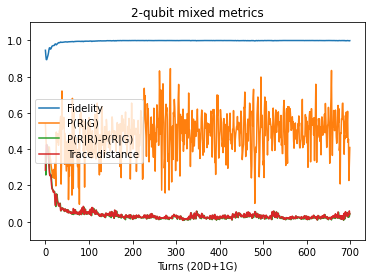

In [17]:
plt.plot(F, label='Fidelity')
plt.plot(Gen_cost, label='P(R|G)')
plt.plot(Disc_cost, label='P(R|R)-P(R|G)')
plt.plot(Trace_d, label='Trace distance')
plt.ylim([-0.1,1.1])
plt.xlabel('Turns (20D+1G)') 
plt.title("2-qubit mixed metrics")
plt.legend()
plt.savefig('Z:\\Quantum Engineering\\3. Semester\Workshop\\qGANs-main\\mixed trials\\1qubit adam.pdf', format='pdf')

In [29]:
from qiskit.visualization import plot_state_city
real_state = real_circuit(real_params).numpy()
plot_state_city(real_state, title='Density Matrix', format='pdf')

TypeError: plot_state_city() got an unexpected keyword argument 'filename'

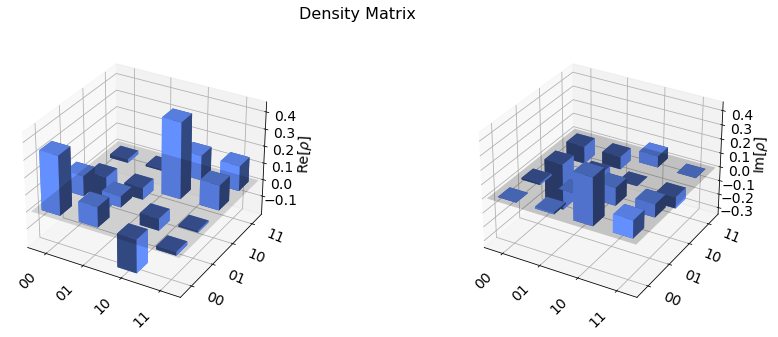

In [21]:
generated_state = gen_circuit(gen_weights).numpy()
plot_state_city(generated_state, title='Density Matrix')

In Qiskit, we can use the plot_bloch_multivector() function to plot the density matrix of our mixed state in the Bloch sphere
to plot the composite state rho_AB, we see we get two Bloch vectors that correctly represent each of these reduced density matrices rho_A and rho_B

In [30]:
from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector(real_state, title='Real mixed state')

TypeError: plot_bloch_multivector() got an unexpected keyword argument 'filename'

C:\Users\sarah\anaconda3\lib\site-packages\qiskit\visualization\bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


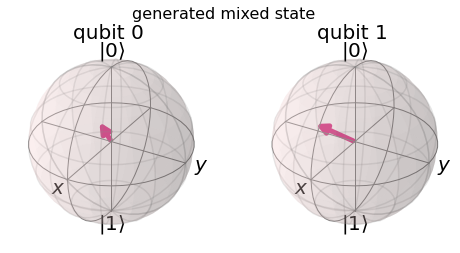

In [25]:
plot_bloch_multivector(generated_state, title='generated mixed state')